In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as sp
import scipy.stats
import os
import scipy.io as sio
import regex as re
from collections import Counter, defaultdict
import sys 

def distance(astring, bstring) :
    distance = 0
    
    limit = len(astring)
    diff = len(bstring) - len(astring)
    if len(bstring) < len(astring) :
        limit = len(bstring)
        diff = len(astring) - len(bstring)
    
    for i in range(limit) :
        if astring[i] != bstring[i] :
            distance += 1
    return distance + diff

print(distance("ATATATGCGCGC", "TTATATCCGCAC"))

3


In [2]:
dna_file = pd.read_csv('apa_nextseq_v2_dna_merged_20160922.csv',sep=',')

dna_upstream_list = list(dna_file.upstream_seq)
dna_pas_list = list(dna_file.pas_seq)
dna_downstream_list = list(dna_file.downstream_seq)
dna_seq_list = list(dna_file.seq)
dna_library_list = list(dna_file.library)

dna_upstream_map = {}
dna_pas_map = {}
dna_downstream_map = {}
dna_seq_map = {}
dna_library_map = {}

for i in range(0, len(dna_upstream_list)) :
    dna_upstream_map[dna_upstream_list[i]] = dna_upstream_list[i]
    dna_pas_map[dna_upstream_list[i]] = dna_pas_list[i]
    dna_downstream_map[dna_upstream_list[i]] = dna_downstream_list[i]
    dna_seq_map[dna_upstream_list[i]] = dna_seq_list[i]
    dna_library_map[dna_upstream_list[i]] = int(dna_library_list[i])

n10_a = re.compile(r"(TGTTAAGAAC[ACGTN]{10}CTGGTAACTGACCTTCAAAG){s<=3}")
n10_b = re.compile(r"(TGTTAAGAACAAGTT[ACGTN]{10}AACTGACCTTCAAAG){s<=3}")
n10_c = re.compile(r"(TGTTAAGAACAAGTTTGGCT[ACGTN]{10}ACCTTCAAAG){s<=3}")

wt20_down = re.compile(r"(GATGTCTCGTGATCTGGTGT){s<=3}")

In [3]:
#Library bias splits
lib_a = re.compile(r"([ACGTN]{20}CTGGTAACTGACCTTCAAAG){s<=3}")
lib_b = re.compile(r"(TGTTAAGAAC[ACGTN]{20}ACCTTCAAAG){s<=3}")
lib_c = re.compile(r"(TGTTAAGAACAAGTTTGGCT[ACGTN]{20}){s<=3}")
lib_d = re.compile(r"(TGTTAAGAAC[ACGTN]{10}CTGGTAACTGACCTTCAAAG){s<=3}")
lib_e = re.compile(r"(TGTTAAGAACAAGTT[ACGTN]{10}AACTGACCTTCAAAG){s<=3}")
lib_f = re.compile(r"(TGTTAAGAACAAGTTTGGCT[ACGTN]{10}ACCTTCAAAG){s<=3}")

libs = [
    [lib_d, [10,20], 1],
    [lib_e, [15,25], 1],
    [lib_f, [20,30], 1],
    [lib_a, [0, 20], 1],
    [lib_b, [10,30], 1],
    [lib_c, [20,40], 1]
]

def get_sequence_lib(seq, libs) :
    for j in range(0, len(libs)) :
        region_regex = libs[j][0]
        if re.search(region_regex, seq) :
            return j, libs[j][1][0], libs[j][1][1]
    return -1, -1, -1


def partition_lib(seqs, libs, seq_start, seq_end) :
    lib_seqs = []
    lib_mappings = []
    for j in range(0, len(libs)) :
        lib_seqs.append([])
        lib_mappings.append([])
    
    seq_i = 0
    for seq in seqs :
        inner_seq = seq[seq_start:seq_end]
        
        lib_i, start_r, end_r = get_sequence_lib(inner_seq, libs)
        if lib_i != -1 :
            lib_seqs[lib_i].append(inner_seq[start_r:end_r])
            lib_mappings[lib_i].append(seq_i)
        seq_i += 1
    return lib_seqs, lib_mappings
    
def mutate_sequences(seqs, mappings, mutate=1) :
    bases = ['A', 'C', 'G', 'T']
    mutants = {}
    
    seq_i = 0
    for seq in seqs :
        if mutate == 1 :
            for i in range(0, len(seq)) :
                for base1 in bases :
                    mutants[seq[0:i] + base1 + seq[i+1:]] = mappings[seq_i]
        elif mutate == 0 :
            mutants[seq] = mappings[seq_i]
        seq_i += 1
    return mutants

CONST_NT_MAP = ['A', 'C', 'G', 'T']

def get_hamming_neighbor_1(seq, seq_map, start_r, end_r) :
    for i in range(start_r, end_r) :
        for base1 in CONST_NT_MAP :
            mut_seq = seq[:i] + base1 + seq[i+1:]
            if mut_seq in seq_map :
                return mut_seq
    return None

def get_hamming_neighbor_2(seq, seq_map, start_r, end_r) :
    for i in range(start_r, end_r) :
        for j in range(i + 1, end_r) :
            for base1 in CONST_NT_MAP :
                for base2 in CONST_NT_MAP :
                    mut_seq = seq[:i] + base1 + seq[i+1:j] + base2 + seq[j+1:]
                    if mut_seq in seq_map :
                        return mut_seq
    return None

lookup_indexes = []

In [4]:
dna_upstream_map_keys = list(dna_upstream_map.keys())

print('Partitioning seq data according to sublibrary bias.')

lib_seqs, lib_mappings = partition_lib(dna_upstream_map_keys, libs, 0, 40)

print('Transforming partitioned seq data to lookup sets.')

lookup_indexes = []

for j in range(0, len(libs)) :
    print('Indexing sublibrary of size: ' + str(len(lib_seqs[j])))
    
    #lookup_indexes.append(mutate_sequences(lib_seqs[j], lib_mappings[j], 0))
    lookup_indexes.append(mutate_sequences(lib_seqs[j], lib_mappings[j], libs[j][2]))

Partitioning seq data according to sublibrary bias.
Transforming partitioned seq data to lookup sets.
Indexing sublibrary of size: 96
Indexing sublibrary of size: 61
Indexing sublibrary of size: 77
Indexing sublibrary of size: 440597
Indexing sublibrary of size: 164891
Indexing sublibrary of size: 496283


In [5]:
rna_file = open('tomm5_rna_polyatail_3errors.csv', 'r')

count = 0

mapped_count = {}
mapped_proximal_count = {}
mapped_proximal_cut = {}
mapped_proximal_cut_prefixed = {}
mapped_distal_count = {}

mapped_umi_map = {}

total_mapped_count = 0
total_mapped_proximal_count = 0
total_mapped_distal_count = 0

bases = ['A', 'C', 'G', 'T']

num_matched_on_dictionary_lookup = 0
num_matched_on_hamming_index = 0

print('Mapping RNA reads to DNA members.')

total_rna_lib_count = [0, 0, 0, 0, 0, 0]
total_mapped_lib_count = [0, 0, 0, 0, 0, 0]


rna_file.readline()

i = 0
for line in rna_file :
    i += 1
    if line is None or len(line) == 0 :
        break
    
    lineparts = line.rstrip().split(',')
    if len(lineparts) != 7 :
        break
    
    upstream_seq = lineparts[0][10:50]
    downstream_seq = lineparts[1]
    if downstream_seq != '' :
        downstream_seq = downstream_seq[10:30]
    
    umi_seq = lineparts[3]
    cut_pos = int(lineparts[4]) - 114 #subtract thrown part of read
    cut_pos_prefixed = int(lineparts[5]) - 114
    is_proximal = int(lineparts[6])
        
    lib_i, start_r, end_r = get_sequence_lib(upstream_seq, libs)
    
    dna_upstream_seq = None
    
    if lib_i == 3 or lib_i == 4 or lib_i == 5 :
        
        '''rna_library = lib_i
        if downstream_seq != '' :
            if re.search(wt20_down, downstream_seq) is not None :
                rna_library = lib_i - 3
            total_rna_lib_count[rna_library] += 1'''
        
        if upstream_seq in dna_upstream_map :
            dna_upstream_seq = upstream_seq
            num_matched_on_dictionary_lookup += 1
        elif lib_i != -1 and upstream_seq[start_r:end_r] in lookup_indexes[lib_i] :
            mapped_upstream_i = lookup_indexes[lib_i][upstream_seq[start_r:end_r]]
            dna_upstream_seq = dna_upstream_map_keys[mapped_upstream_i]
            num_matched_on_hamming_index += 1
        
        if dna_upstream_seq != None :
            if distance(upstream_seq[start_r:end_r], dna_upstream_seq[start_r:end_r]) > 1 :
                print("ERROR!")
                break
            
            total_mapped_lib_count[dna_library_map[dna_upstream_seq]] += 1
            
            dna_downstream_seq = dna_downstream_map[dna_upstream_seq]
            
            if dna_upstream_seq not in mapped_count :
                mapped_count[dna_upstream_seq] = 0
                mapped_proximal_count[dna_upstream_seq] = 0
                mapped_distal_count[dna_upstream_seq] = 0
                mapped_umi_map[dna_upstream_seq] = {}
                
                mapped_proximal_cut[dna_upstream_seq] = []#{}
                mapped_proximal_cut_prefixed[dna_upstream_seq] = []#{}
            
            is_dup_umi = False
            
            #Exact match UMI
            if umi_seq in mapped_umi_map[dna_upstream_seq] :
                is_dup_umi = True
            else :
                for ref_umi in mapped_umi_map[dna_upstream_seq] :
                    if distance(umi_seq, ref_umi) <= 2 :
                        is_dup_umi = True
                        mapped_umi_map[dna_upstream_seq][umi_seq] = True
                        break
            
            if is_dup_umi == False :
                mapped_umi_map[dna_upstream_seq][umi_seq] = True
                
                if is_proximal == 1 :
                    #Proximal
                    mapped_proximal_count[dna_upstream_seq] += 1
                    mapped_count[dna_upstream_seq] += 1
                    total_mapped_proximal_count += 1
                    total_mapped_count += 1
                        
                    '''if cut_pos not in mapped_proximal_cut[dna_upstream_seq] :
                        mapped_proximal_cut[dna_upstream_seq][cut_pos] = 0
                    mapped_proximal_cut[dna_upstream_seq][cut_pos] += 1
                    
                    if cut_pos_prefixed not in mapped_proximal_cut_prefixed[dna_upstream_seq] :
                        mapped_proximal_cut_prefixed[dna_upstream_seq][cut_pos_prefixed] = 0
                    mapped_proximal_cut_prefixed[dna_upstream_seq][cut_pos_prefixed] += 1'''
                    
                    mapped_proximal_cut[dna_upstream_seq].append(cut_pos)
                    mapped_proximal_cut_prefixed[dna_upstream_seq].append(cut_pos_prefixed)
                    
                elif downstream_seq != '' and distance(downstream_seq, dna_downstream_seq) <= 3 :
                    #Distal
                    mapped_distal_count[dna_upstream_seq] += 1
                    mapped_count[dna_upstream_seq] += 1
                    total_mapped_distal_count += 1
                    total_mapped_count += 1
        
        if count % 1000000 == 0:
            print('Count: ' + str(count))
            print('Matched on Dict lookup: ' + str(num_matched_on_dictionary_lookup))
            print('Matched on Hamming index: ' + str(num_matched_on_hamming_index))
            
            print(str(len(mapped_count)) + ' mapped unique library members')
            
            print(str(total_mapped_proximal_count) + ' mapped proximal RNA reads')
            print(str(total_mapped_distal_count) + ' mapped distal RNA reads')
            
            print('Extracted RNA library distribution: ' + str(total_rna_lib_count))
            print('Mapped library distribution: ' + str(total_mapped_lib_count))
        count += 1

print('COMPLETE')
print(str(len(mapped_count)) + ' mapped unique library members')
print(str(total_mapped_count) + ' mapped RNA reads')
print(str(total_mapped_proximal_count) + ' mapped proximal RNA reads')
print(str(total_mapped_distal_count) + ' mapped distal RNA reads')

print('Extracted RNA library distribution: ' + str(total_rna_lib_count))
print('Mapped library distribution: ' + str(total_mapped_lib_count))

rna_file.close()

mapped_upstream_list = []
mapped_pas_list = []
mapped_downstream_list = []
mapped_seq_list = []
mapped_proximal_list = []
mapped_proximal_cut_list = []
mapped_proximal_cut_prefixed_list = []
mapped_distal_list = []
mapped_count_list = []
mapped_library_list = []

i = 0
for upstream_seq in mapped_count :
    if mapped_count[upstream_seq] > 0 :
        mapped_upstream_list.append(upstream_seq)
        mapped_pas_list.append(dna_pas_map[upstream_seq])
        mapped_downstream_list.append(dna_downstream_map[upstream_seq])
        mapped_seq_list.append(dna_seq_map[upstream_seq])
        mapped_proximal_list.append(mapped_proximal_count[upstream_seq])
        mapped_distal_list.append(mapped_distal_count[upstream_seq])
        mapped_count_list.append(mapped_count[upstream_seq])
        mapped_library_list.append(dna_library_map[upstream_seq])
        
        mapped_proximal_cut_list.append(str(mapped_proximal_cut[upstream_seq]))
        mapped_proximal_cut_prefixed_list.append(str(mapped_proximal_cut_prefixed[upstream_seq]))
        
print(str(len(mapped_upstream_list)) + ' kept library members')

df = pd.DataFrame({'upstream'  : mapped_upstream_list,
                   'pas'  : mapped_pas_list,
                   'downstream'  : mapped_downstream_list,
                   'seq'  : mapped_seq_list,
                   'library' : mapped_library_list,
                   'proximal_count'  : mapped_proximal_list,
                   'distal_count' : mapped_distal_list,
                   'total_count' : mapped_count_list,
                   'proximal_cut' : mapped_proximal_cut_list,
                   'proximal_cut_prefixed' : mapped_proximal_cut_prefixed_list})

df = df.sort_values(by = 'total_count').reset_index(drop=True)

print(len(df))

new_columns = ['upstream', 'pas', 'downstream', 'seq', 'library', 'proximal_count', 'distal_count', 'total_count', 'proximal_cut', 'proximal_cut_prefixed']
df.to_csv('tomm5_readmatch_hamming1_umimatch_hamming2.csv', columns=new_columns, index=False)


Mapping RNA reads to DNA members.
Count: 0
Matched on Dict lookup: 1
Matched on Hamming index: 0
1 mapped unique library members
0 mapped proximal RNA reads
1 mapped distal RNA reads
Extracted RNA library distribution: [0, 0, 0, 0, 0, 0]
Mapped library distribution: [0, 0, 1, 0, 0, 0]
Count: 1000000
Matched on Dict lookup: 696702
Matched on Hamming index: 108646
456894 mapped unique library members
277541 mapped proximal RNA reads
450608 mapped distal RNA reads
Extracted RNA library distribution: [0, 0, 0, 0, 0, 0]
Mapped library distribution: [263031, 93, 258017, 46547, 43, 237617]
Count: 2000000
Matched on Dict lookup: 1398672
Matched on Hamming index: 217584
628481 mapped unique library members
528697 mapped proximal RNA reads
881853 mapped distal RNA reads
Extracted RNA library distribution: [0, 0, 0, 0, 0, 0]
Mapped library distribution: [527295, 198, 512625, 95175, 88, 480875]
Count: 3000000
Matched on Dict lookup: 2098614
Matched on Hamming index: 327436
708290 mapped unique lib

Count: 27000000
Matched on Dict lookup: 18644600
Matched on Hamming index: 3106136
819670 mapped unique library members
4032173 mapped proximal RNA reads
6771213 mapped distal RNA reads
Extracted RNA library distribution: [0, 0, 0, 0, 0, 0]
Mapped library distribution: [7117028, 2298, 6906109, 1294724, 1167, 6429410]
Count: 28000000
Matched on Dict lookup: 19355935
Matched on Hamming index: 3206361
819712 mapped unique library members
4104896 mapped proximal RNA reads
6930153 mapped distal RNA reads
Extracted RNA library distribution: [0, 0, 0, 0, 0, 0]
Mapped library distribution: [7380508, 2389, 7164210, 1342747, 1218, 6671224]
Count: 29000000
Matched on Dict lookup: 20064335
Matched on Hamming index: 3310746
819753 mapped unique library members
4172264 mapped proximal RNA reads
7080235 mapped distal RNA reads
Extracted RNA library distribution: [0, 0, 0, 0, 0, 0]
Mapped library distribution: [7643690, 2463, 7418908, 1391914, 1262, 6916844]
Count: 30000000
Matched on Dict lookup: 207

In [6]:
df = None
prox_cuts = None
prox_cuts_prefixed = None

In [6]:
df_filename = 'tomm5_readmatch_hamming1_umimatch_hamming2'

df = pd.read_csv(df_filename + '.csv', delimiter=',')
print(len(df))

#df = df[df.total_count >= 10].reset_index(drop=True)
#print(len(df))

819599


In [7]:

import scipy.sparse as sp

prox_cuts = sp.lil_matrix((len(df), 93))
prox_cuts_prefixed = sp.lil_matrix((len(df), 93))

i = 0
for index, row in df.iterrows() :
    if index % 100000 == 0 :
        print('Processing cuts for index = ' + str(i))
    
    prox_list = []
    
    if len(row['proximal_cut']) > 2 and ',' not in row['proximal_cut'] :
        prox_list = [row['proximal_cut'][1:-1]]
    elif len(row['proximal_cut']) > 2 :
        prox_list = row['proximal_cut'][1:-1].split(', ')
    
    prox_list_prefixed = []
    
    if len(row['proximal_cut_prefixed']) > 2 and ',' not in row['proximal_cut_prefixed'] :
        prox_list_prefixed = [row['proximal_cut_prefixed'][1:-1]]
    elif len(row['proximal_cut_prefixed']) > 2 :
        prox_list_prefixed = row['proximal_cut_prefixed'][1:-1].split(', ')
    
    for prox_pos_str in prox_list :
        prox_pos = int(prox_pos_str)
        if prox_pos >= 0 and prox_pos < 93 :
            prox_cuts[index, int(prox_pos_str)] += 1
    for prox_pos_prefix_str in prox_list_prefixed :
        prox_pos = int(prox_pos_prefix_str)
        if prox_pos >= 0 and prox_pos < 93 :
            prox_cuts_prefixed[index, int(prox_pos_prefix_str)] += 1

    i += 1

prox_cuts = sp.csr_matrix(prox_cuts)
prox_cuts_prefixed = sp.csr_matrix(prox_cuts_prefixed)

Processing cuts for index = 0
Processing cuts for index = 100000
Processing cuts for index = 200000
Processing cuts for index = 300000
Processing cuts for index = 400000
Processing cuts for index = 500000
Processing cuts for index = 600000
Processing cuts for index = 700000
Processing cuts for index = 800000


In [8]:
import scipy.io as spio

spio.savemat(df_filename + '_cuts', {'proximal' : prox_cuts, 'proximal_prefixed' : prox_cuts_prefixed})


In [9]:
import matplotlib.pyplot as plt
import operator

cut_mer2 = {}

seqs = list(df['seq'].values)
seqs = np.array(seqs, dtype=np.object)

cx = sp.coo_matrix(prox_cuts)

for i,j,v in zip(cx.row, cx.col, cx.data) :
    seq = seqs[i]
    
    mer2 = seq[j-1:j+1]
    if mer2 not in cut_mer2 :
        cut_mer2[mer2] = 0
    cut_mer2[mer2] += 1

cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

mer2_list = []
mer2_vals = []
for i in range(0, len(cut_mer2_sorted)) :
    mer2_list.append(cut_mer2_sorted[i][0])
    mer2_vals.append(cut_mer2_sorted[i][1])

f = plt.figure(figsize=(6, 4))

plt.bar(mer2_list, mer2_vals, color='black')

plt.title('Proximal cleavage dinuc.', fontsize=14)
plt.xlabel('Dinucleotide', fontsize=14)
plt.ylabel('Read count', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

<Figure size 600x400 with 1 Axes>

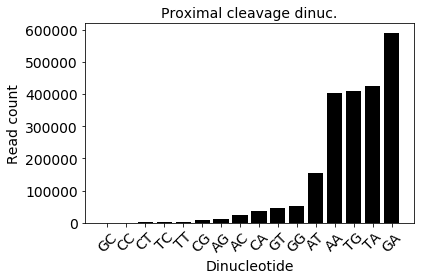

In [10]:
import matplotlib.pyplot as plt
import operator

cut_mer2 = {}

seqs = list(df['seq'].values)
seqs = np.array(seqs, dtype=np.object)

cx = sp.coo_matrix(prox_cuts_prefixed)

for i,j,v in zip(cx.row, cx.col, cx.data) :
    seq = seqs[i]
    
    mer2 = seq[j-1:j+1]
    if mer2 not in cut_mer2 :
        cut_mer2[mer2] = 0
    cut_mer2[mer2] += 1

cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

mer2_list = []
mer2_vals = []
for i in range(0, len(cut_mer2_sorted)) :
    mer2_list.append(cut_mer2_sorted[i][0])
    mer2_vals.append(cut_mer2_sorted[i][1])

f = plt.figure(figsize=(6, 4))

plt.bar(mer2_list, mer2_vals, color='black')

plt.title('Proximal cleavage dinuc.', fontsize=14)
plt.xlabel('Dinucleotide', fontsize=14)
plt.ylabel('Read count', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

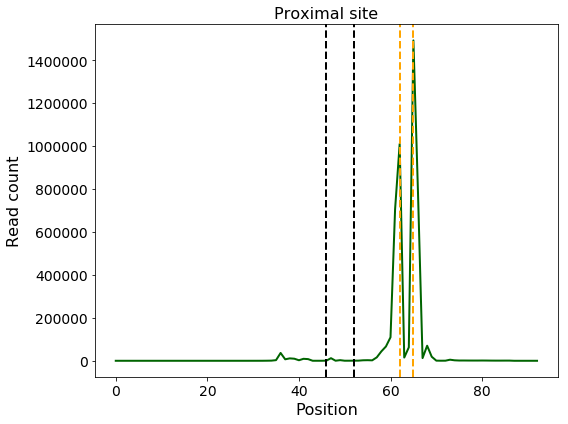

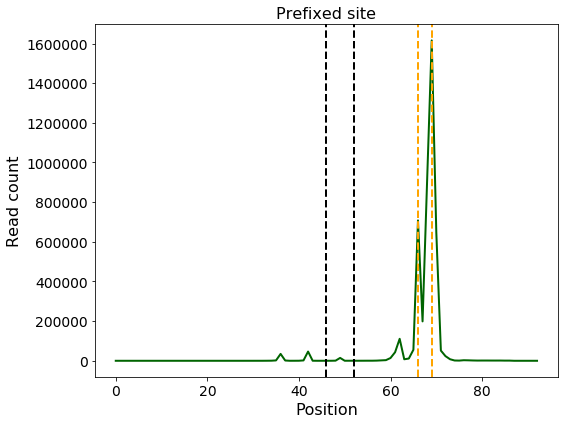

In [11]:

proximal_profile = np.ravel(prox_cuts.sum(axis=0))
prefixed_profile = np.ravel(prox_cuts_prefixed.sum(axis=0))

figure_suffix = '_with_dna_antimisprime'

f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(proximal_profile)), proximal_profile, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=46, linewidth=2, c='black', linestyle='--')
plt.axvline(x=46 + 6, linewidth=2, c='black', linestyle='--')

plt.axvline(x=46 + 16, linewidth=2, c='orange', linestyle='--')
plt.axvline(x=46 + 19, linewidth=2, c='orange', linestyle='--')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

#plt.savefig('doubledope_proximal_cut_profile' + figure_suffix + '.png')
plt.show()


f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(prefixed_profile)), prefixed_profile, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=46, linewidth=2, c='black', linestyle='--')
plt.axvline(x=46 + 6, linewidth=2, c='black', linestyle='--')

plt.axvline(x=46 + 20, linewidth=2, c='orange', linestyle='--')
plt.axvline(x=46 + 23, linewidth=2, c='orange', linestyle='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Prefixed site', fontsize=16)
plt.tight_layout()

#plt.savefig('doubledope_distal_cut_profile' + figure_suffix + '.png')
plt.show()


In [ ]:
'TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGT'

In [45]:
print(len('TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAA'))

46


In [54]:
print('TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGT'[46 + 16 - 1:])
print('TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGT'[46 + 19 - 1:])

GAAGTATGAAACGATGTCTCGTGATCTGGTGT
GTATGAAACGATGTCTCGTGATCTGGTGT


In [57]:
print('TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGT'[46 + 20 - 1:])
print('TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGT'[46 + 23 - 1:])

TATGAAACGATGTCTCGTGATCTGGTGT
GAAACGATGTCTCGTGATCTGGTGT


In [44]:
print(df.iloc[0])

upstream                                                                      TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAG
pas                                                                                                    CTAAAATATAAAACT
downstream                                                                                        GATGTCTCGTGATCTGGTGT
seq                      TGTTAAGAACAAGTTTGGCTGTGGAGTTAGACTAAGCTAGCTAAAATATAAAACTATTTGGGAAGTATGAAACGATGTCTCGTGATCTGGTGT
library                                                                                                              2
proximal_count                                                                                                       0
distal_count                                                                                                         1
total_count                                                                                                          1
proximal_cut                                    